## Project 5 - Recommendation Systems

Team members: Vamshi Gujjari, Hemant Koti <br>

In this notebook, we will describe a collaborative filtering recommendation system using the traditional machine learning approach (SVD) in part I and the deep learning method in part II. <br>

[Dataset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) <br>
[Model](https://drive.google.com/file/d/1--bNbYaD4ENYfdxJDM-Faz_Hcb8MCy9U/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget -P 'drive/My Drive/Colab Notebooks' http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-08-18 00:35:17--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘drive/My Drive/Colab Notebooks/ml-latest-small.zip.6’

ml-latest-small.zip 100%[===================>] 955.28K  3.34MB/s    in 0.3s    

2020-08-18 00:35:18 (3.34 MB/s) - ‘drive/My Drive/Colab Notebooks/ml-latest-small.zip.6’ saved [978202/978202]



In [3]:
!unzip 'drive/My Drive/Colab Notebooks/ml-latest-small.zip' -d 'drive/My Drive/Colab Notebooks/'

Archive:  drive/My Drive/Colab Notebooks/ml-latest-small.zip
replace drive/My Drive/Colab Notebooks/ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace drive/My Drive/Colab Notebooks/ml-latest-small/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace drive/My Drive/Colab Notebooks/ml-latest-small/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace drive/My Drive/Colab Notebooks/ml-latest-small/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace drive/My Drive/Colab Notebooks/ml-latest-small/movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer, scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df_movies = pd.read_csv("drive/My Drive/Colab Notebooks/ml-latest-small/movies.csv")
df_tags = pd.read_csv("drive/My Drive/Colab Notebooks/ml-latest-small/tags.csv")
df_ratings = pd.read_csv("drive/My Drive/Colab Notebooks/ml-latest-small/ratings.csv")

### Part I: ML Method for Recommendations


#### 1. Preprocess the dataset. Highlight main statistics about it.

In [6]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
df_tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [11]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [12]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [14]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [15]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [16]:
df_tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [17]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

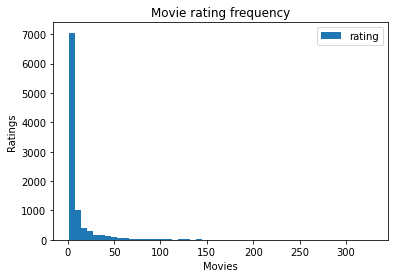

In [18]:
movie_rating_frequency = df_ratings[['movieId', 'rating']].groupby('movieId').count()
movie_rating_frequency.plot.hist(bins=50)

plt.xlabel('Movies')
plt.ylabel('Ratings')
plt.title('Movie rating frequency')
plt.legend()

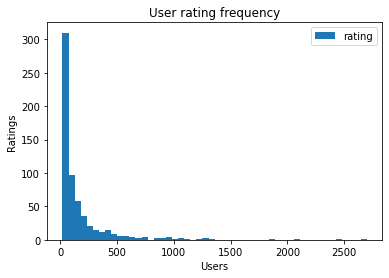

In [ ]:
user_rating_frequency = df_ratings[['userId', 'rating']].groupby('userId').count()
user_rating_frequency.plot.hist(bins=50)

plt.xlabel('Users')
plt.ylabel('Ratings')
plt.title('User rating frequency')
plt.legend()

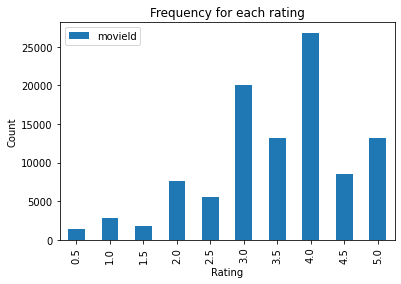

In [19]:
rating_frequency = df_ratings[['rating', 'movieId']].groupby('rating').count()
rating_frequency.plot(kind='bar')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Frequency for each rating')
plt.legend()

In [20]:
movies_and_ratings = df_movies.merge(df_ratings, on='movieId', how='inner')

In [21]:
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [22]:
movies_and_ratings.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


In [23]:
import collections
collections.Counter(" ".join(movies_and_ratings['genres']).split('|')).most_common(10)

[('Drama', 16366),
 ('Adventure', 13263),
 ('Thriller Action', 11764),
 ('Comedy', 10206),
 ('Crime', 7699),
 ('Sci-Fi', 7667),
 ('Romance Comedy', 7634),
 ('Children', 6621),
 ('Fantasy', 6281),
 ('Mystery', 5289)]

In [24]:
rating_pivot = df_ratings.pivot(index='userId', columns="movieId", values="rating").fillna(0)
rating_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
np_rating = rating_pivot.to_numpy()
rating_mean = np.mean(np_rating, axis = 1)
np_rating = np_rating - rating_mean.reshape(-1,1)

#### 2. Choose any machine learning method used for recommendation system (**SVD**).

In [26]:
from scipy.sparse.linalg import svds

In [27]:
U, sigma, Vt = svds(np_rating, k = 50)

In [28]:
sigma = np.diag(sigma)

Given the user ID and number of recommendations, the model generates recommendations and displays for the current user.

In [29]:
USERID = 12
RECOMMENDATIONS = 5
THRESHOLD = 30

In [30]:
user_pred_ratings = np.dot(np.dot(U, sigma), Vt) + rating_mean.reshape(-1, 1)
user_pred_ratings_df = pd.DataFrame(user_pred_ratings, columns=rating_pivot.columns).iloc[USERID].sort_values(ascending = False)

In [31]:
user_pred_ratings.shape

(610, 9724)

In [32]:
user_ratings = df_ratings[df_ratings['userId'] == USERID]

Number of movies the given user has rated in the complete movie list is given below

In [33]:
complete_movie_ratings = user_ratings.merge(df_movies, how='left', on="movieId").sort_values(['rating'], ascending = False)

In [34]:
complete_movie_ratings

,userId,movieId,rating,timestamp,title,genres
16,12,2072,5.0,1247263670,"'burbs, The (1989)",Comedy
12,12,1357,5.0,1247263404,Shine (1996),Drama|Romance
30,12,40629,5.0,1247264192,Pride & Prejudice (2005),Drama|Romance
29,12,8533,5.0,1247264151,"Notebook, The (2004)",Drama|Romance
28,12,6942,5.0,1247264138,Love Actually (2003),Comedy|Drama|Romance
24,12,3668,5.0,1247264220,Romeo and Juliet (1968),Drama|Romance
23,12,2717,5.0,1247263428,Ghostbusters II (1989),Comedy|Fantasy|Sci-Fi
21,12,2581,5.0,1247263444,Never Been Kissed (1999),Comedy|Romance
20,12,2572,5.0,1247263689,10 Things I Hate About You (1999),Comedy|Romance
19,12,2485,5.0,1247264406,She's All That (1999),Comedy|Romance


#### 3. Given a completely new user in the system, return a list of recommended movies. Reason your choice.


In [35]:
new_user_rec = df_ratings.groupby("movieId").agg(
    {'timestamp':'size', 'rating':'mean'}).rename(columns = {'timestamp':'number of reviews'}).reset_index().sort_values(
        'rating', ascending = False).merge(
            df_movies, how='left', on='movieId')
new_user_rec[new_user_rec['number of reviews']>THRESHOLD].sort_values('rating', ascending=False)[:RECOMMENDATIONS]

,movieId,number of reviews,rating,title,genres
722,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
791,1204,45,4.300000,Lawrence of Arabia (1962),Adventure|Drama|War
800,858,192,4.289062,"Godfather, The (1972)",Crime|Drama
808,2959,218,4.272936,Fight Club (1999),Action|Crime|Drama|Thriller
809,1276,57,4.271930,Cool Hand Luke (1967),Drama


The recommendations for a completely new user are given based on the ratings given by all the users in the current dataset and a threshold of 30 reviews is applied on them, so that the final outcome will be the best movies rated by at least 30 people in the given system. 

#### 4. Given an existing user ID and other attributes as an input, return a list of recommended movies (including movie’s names). This has to be based on the expected rating by that user.

In [36]:
recommendations = df_movies[~df_movies['movieId'].isin(complete_movie_ratings['movieId'])].merge(
    pd.DataFrame(user_pred_ratings_df).reset_index(), how='left', on='movieId'
).rename(columns = {USERID : 'Predictions'}).sort_values('Predictions',ascending = False).iloc[:RECOMMENDATIONS,:-1]

In [37]:
recommendations[:RECOMMENDATIONS]

,movieId,title,genres
1919,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2650,3578,Gladiator (2000),Action|Adventure|Drama
3611,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
2202,2959,Fight Club (1999),Action|Crime|Drama|Thriller
2957,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance


#### 5. Discuss the results.

As shown above the recommendations for User ID: 12 are generated based on the SVD method and this is useful in capturing the features of the dataset which serve as a good starting point for recommendation systems without the need for domain knowledge. <br>

However, the prediction output is less in the case of SVD as it cannot incorporate any side features. To encounter this we use the deep learning approach.

### Part II: Deep Learning Methods for Recommendations


#### 1. Prepare the dataset for training.

In [38]:
import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential

In [39]:
train, test = train_test_split(movies_and_ratings[['userId', 'movieId', 'rating']], test_size = 0.1, random_state = 42)

In [40]:
train.head()

,userId,movieId,rating
14430,162,534,5.0
43498,28,2412,2.0
73590,398,7099,4.5
19181,492,785,5.0
97254,298,112552,3.5


In [41]:
test.head()

,userId,movieId,rating
67037,599,5418,3.0
42175,282,2329,4.5
93850,282,91529,4.0
6187,414,230,3.0
12229,136,440,5.0


In [42]:
print(train.shape, test.shape)

(90752, 3) (10084, 3)


In [43]:
n_users = df_ratings['userId'].nunique()+1
n_movies = df_ratings['movieId'].drop_duplicates().max()+1

In [44]:
print(n_users, n_movies)

611 193610


#### 2. Choose any deep learning method used for recommendation system

In [45]:
output_dimensions = 100

In [46]:
movie_input = Input(shape=[1])
movie_embedding = Embedding(n_movies, output_dimensions)(movie_input)
movie_vec = Flatten()(movie_embedding)

user_input = Input(shape=[1])
user_embedding = Embedding(n_users, output_dimensions)(user_input)
user_vec = Flatten()(user_embedding)

In [47]:
input = Concatenate()([user_vec, movie_vec])

In [48]:
model = Sequential()

x = Dense(128, activation='relu')(input)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1)(x)
output = Activation('linear')(output)

In [49]:
model = Model([user_input, movie_input], output)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

#### 3. Describe the model, hyperparameters, accuracy/loss, etc. Show the list of recommended movies.

In [50]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       61100       input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       19361000    input_1[0][0]                    
_______________________________________________________________________________________

In [51]:
history = model.fit([train.userId, train.movieId], train.rating, batch_size=64, epochs=15, verbose=2, validation_split=0.1)

Epoch 1/15
1277/1277 - 219s - loss: 2.1932 - val_loss: 0.8761
Epoch 2/15
1277/1277 - 217s - loss: 0.8686 - val_loss: 0.7899
Epoch 3/15
1277/1277 - 218s - loss: 0.7276 - val_loss: 0.7782
Epoch 4/15
1277/1277 - 217s - loss: 0.6616 - val_loss: 0.7839
Epoch 5/15
1277/1277 - 218s - loss: 0.6131 - val_loss: 0.7763
Epoch 6/15
1277/1277 - 218s - loss: 0.5623 - val_loss: 0.7954
Epoch 7/15
1277/1277 - 218s - loss: 0.5057 - val_loss: 0.8200
Epoch 8/15
1277/1277 - 221s - loss: 0.4650 - val_loss: 0.8182
Epoch 9/15
1277/1277 - 224s - loss: 0.4275 - val_loss: 0.8343
Epoch 10/15
1277/1277 - 220s - loss: 0.3919 - val_loss: 0.8890
Epoch 11/15
1277/1277 - 219s - loss: 0.3687 - val_loss: 0.8684
Epoch 12/15
1277/1277 - 221s - loss: 0.3482 - val_loss: 0.8405
Epoch 13/15
1277/1277 - 222s - loss: 0.3346 - val_loss: 0.8616
Epoch 14/15
1277/1277 - 223s - loss: 0.3176 - val_loss: 0.8612
Epoch 15/15
1277/1277 - 223s - loss: 0.3054 - val_loss: 0.8814


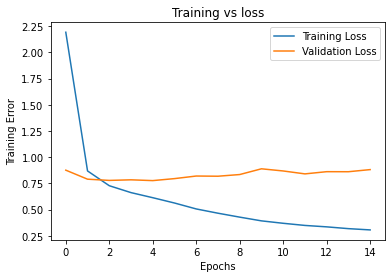

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training vs loss')
plt.legend()

In [53]:
model.save('drive/My Drive/Colab Notebooks/dl_recommendation_model_1.h5')

In [54]:
model =  keras.models.load_model('drive/My Drive/Colab Notebooks/dl_recommendation_model_1.h5')

In [55]:
user_ratings = df_ratings[df_ratings['userId'] == USERID]

In [56]:
user_ratings.shape

(32, 4)

In [57]:
complete_movie_ratings = user_ratings.merge(df_movies, how='left', on="movieId").sort_values(['rating'], ascending = False)

In [58]:
complete_movie_ratings.shape

(32, 6)

In [59]:
def predict_rating(user_id, movie_id):
    return model.predict([np.array([user_id - 1]), np.array([movie_id - 1])])[0][0]

In [60]:
complete_movie_ratings['prediction'] = complete_movie_ratings.apply(lambda x: predict_rating(USERID, x['movieId']), axis=1)
complete_movie_ratings.sort_values(['rating'], ascending=False)

,userId,movieId,rating,timestamp,title,genres,prediction
16,12,2072,5.0,1247263670,"'burbs, The (1989)",Comedy,3.705456
1,12,168,5.0,1247264411,First Knight (1995),Action|Drama|Romance,3.633225
12,12,1357,5.0,1247263404,Shine (1996),Drama|Romance,4.524785
9,12,838,5.0,1247264096,Emma (1996),Comedy|Drama|Romance,4.152966
3,12,256,5.0,1247263375,Junior (1994),Comedy|Sci-Fi,2.406887
2,12,222,5.0,1247263465,Circle of Friends (1995),Drama|Romance,3.855340
31,12,63992,5.0,1247264457,Twilight (2008),Drama|Fantasy|Romance|Thriller,3.762472
14,12,1721,5.0,1247264463,Titanic (1997),Drama|Romance,3.776382
19,12,2485,5.0,1247264406,She's All That (1999),Comedy|Romance,4.079384
20,12,2572,5.0,1247263689,10 Things I Hate About You (1999),Comedy|Romance,4.353829


In [61]:
recommendations = df_ratings[df_ratings['movieId'].isin(complete_movie_ratings['movieId']) == False][['movieId']].drop_duplicates()
recommendations = recommendations.merge(df_movies, how='left', on="movieId")

In [62]:
recommendations.shape

(9692, 3)

In [63]:
recommendations

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,6,Heat (1995),Action|Crime|Thriller
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...
9687,160341,Bloodmoon (1997),Action|Thriller
9688,160527,Sympathy for the Underdog (1971),Action|Crime|Drama
9689,160836,Hazard (2005),Action|Drama|Thriller
9690,163937,Blair Witch (2016),Horror|Thriller


In [64]:
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(USERID, x['movieId']), axis=1)

The recommendations for User 12 are listed based on the highest prediction accuracy.

In [69]:
recommendations.sort_values(['prediction'], ascending=False).head(RECOMMENDATIONS).iloc[:,:-1]

,movieId,title,genres
1191,7843,Lammbock (2001),Comedy
8711,3940,Slumber Party Massacre III (1990),Horror
490,41,Richard III (1995),Drama|War
9418,4357,How to Marry a Millionaire (1953),Comedy|Drama|Romance
2723,1273,Down by Law (1986),Comedy|Drama|Film-Noir


The recommendations for a completely new user are given based on the ratings given by all the users in the current dataset and a threshold of 30 reviews is applied on them, so that the final outcome will be the best movies rated by at least 30 people in the given system. 

In [66]:
new_user_rec = df_ratings.groupby("movieId").agg(
    {'timestamp':'size', 'rating':'mean'}).rename(columns = {'timestamp':'number of reviews'}).reset_index().sort_values(
        'rating', ascending = False).merge(
            df_movies, how='left', on='movieId')
new_user_rec[new_user_rec['number of reviews']>THRESHOLD].sort_values('rating', ascending=False)[:RECOMMENDATIONS]

,movieId,number of reviews,rating,title,genres
722,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
791,1204,45,4.300000,Lawrence of Arabia (1962),Adventure|Drama|War
800,858,192,4.289062,"Godfather, The (1972)",Crime|Drama
808,2959,218,4.272936,Fight Club (1999),Action|Crime|Drama|Thriller
809,1276,57,4.271930,Cool Hand Luke (1967),Drama


#### 4. Discuss the results of how a deep learning method works for recommendation problems. Compare with the results from Part I.

Deep learning methods can address the problems of matrix factorization as discussed in part I. Using deep learning methods we incorporated side features in the input embedding vector, which can help capture the specific interests of a user and improve the relevance of recommendations. <br>

Compared to Part I there is an improvement observed in the prediction results for recommending to an existing user.

### References

##### *Datasets*
1. http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

##### *Code*
1. https://www.kaggle.com/abhikjha/movielens-fastai-collab
2. https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
3. https://nbviewer.jupyter.org/github/khanhnamle1994/movielens/blob/master/Deep_Learning_Model.ipynb

##### *Readings*
1. http://web.mit.edu/course/other/be.400/OldFiles/www/SVD/Singular_Value_Decomposition.htm
2. https://developers.google.com/machine-learning/recommendation
3. https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby